In [74]:
# Libraries Needed
!pip install wandb -q
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!apt-get install x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


###Run Settings

In [0]:
# wandb metric tracking
log_metrics = True

# Cuda
use_cuda = True 

# Google Colab
use_colab = True

### Import Libraries

In [0]:
# Import Libraries
import wandb

import configparser
import gym
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

from collections import deque

import random

from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import os

Google Colab Setup

In [77]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Variable Setup

In [0]:
project_dir = "/content/gdrive/My Drive/Colab Notebooks/Paper Implementation/Playing-Atari-with-Deep-Reinforcement-Learning/"

### Metric Tracking Setup

In [79]:
  # Wandb Login
if log_metrics:
  config = configparser.ConfigParser()
  config.sections()
  config.read(project_dir + '/config.ini')

  login = config['WANDB']['login']
  entity = config['WANDB']['entity']
  project = config['WANDB']['project']

  wandb.login(login)
  wandb.init(entity=entity, project=project, anonymous='never')

### Cuda Setup

In [80]:
if use_cuda and not torch.cuda.is_available():
  print ("WARNING: cuda is not available")
  use_cuda = False

## Replay Buffer

In [0]:
class ReplayBuffer(object):
  def __init__(self, size):
    self.replayBuffer = deque(maxlen=size)
  
  def add(self, current_state, action, next_state, done):
    self.replayBuffer.append((state, action, reward, next_state, done))

  def sample(self, numSamples):
    state, action, reward, next_state, done = random.sample(self.replayBuffer, numSamples)
  
    return state, action, reward, next_state, done
  
  def __len__(self):
    return len(self.replayBuffer)

###Epsilon Decay
- Decaying epsilon per episode
- Using a class so that different epsilon decay methods could be swapped in and out



In [0]:
class EpsilonDecay(object):
  def __init__(self, start_epsilon, final_epsilon, decay_epsilon):
    self.start_epsilon = start_epsilon
    self.final_epsilon = final_epsilon
    self.decay_epsilon = decay_epsilon
    self.current_epsilon = start_epsilon
  
  def decay(self):
    if self.current_epsilon > self.final_epsilon:
      self.current_epsilon *= self.decay_epsilon
    return self.current_epsilon
  
  def get_epsilon(self):
    return self.current_epsilon
    
  def reset(self, new_epsilon=None):
    if new_epsilon is None:
      self.current_epsilon = self.start_epsilon
    else:
      self.current_epsilon = new_epsilon

    return self.current_epsilon

## Deep Q Network

In [120]:
class testDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, replay_buffer, epsilon):
        super(testDQN, self).__init__()
        self.replay_buffer = replay_buffer # Replay Buffer
        self.num_actions = num_actions
        self.epsilon = epsilon
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
    
    def action(self, state):
        if np.random.rand() <= self.epsilon.get_epsilon():  
            return random.randrange(self.num_actions)

        state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
        q_value = self.layers(state)
        return q_value.max(1)[1].data[0]

    def memorize(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, nextState, done))

    def learn(self, batch):
        if len(self.replay_buffer) < batch:
            return

        state, action, reward, next_state, done = self.replay_buffer.sample(batch)


'''class DQN(nn.Module):
  def __init__(self, numInputs, numActions):
    self.layers == nn.Sequential(
        # 16 8x8 filters, stride 4 -> rectifier nonlinearity
        nn.Conv2d(numInputs, 32, kernel_size=(8,8), stride=4),
        nn.ReLu(),
        # 32 4x4 filter, stride 2 -> rectifier nonlinearity
        nn.Conv2d(32,64, kernel_size=(4,4), stride=2),
        nn.ReLU(),
        # fully connected, 256 rectifier
        nn.Linear(64, 256),
        nn.ReLU(),
        # fully connected  
        nn.Linear(256, numActions)
    )
        
  def forward(self, x):
    x = self.layers(x)
    return x
  
  #def act(self, state, epsilon):
    #if random.random() > epsilon):'''
    

'class DQN(nn.Module):\n  def __init__(self, numInputs, numActions):\n    self.layers == nn.Sequential(\n        # 16 8x8 filters, stride 4 -> rectifier nonlinearity\n        nn.Conv2d(numInputs, 32, kernel_size=(8,8), stride=4),\n        nn.ReLu(),\n        # 32 4x4 filter, stride 2 -> rectifier nonlinearity\n        nn.Conv2d(32,64, kernel_size=(4,4), stride=2),\n        nn.ReLU(),\n        # fully connected, 256 rectifier\n        nn.Linear(64, 256),\n        nn.ReLU(),\n        # fully connected  \n        nn.Linear(256, numActions)\n    )\n        \n  def forward(self, x):\n    x = self.layers(x)\n    return x\n  \n  #def act(self, state, epsilon):\n    #if random.random() > epsilon):'

### Display

In [121]:
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1037'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1037'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

### Cart Pole Environment

In [0]:
env = gym.make("CartPole-v0")
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

### Algorithm 1 - Deep Q-Learning with Experience Replay

In [0]:
replay_buffer = ReplayBuffer(10)
epsilon = EpsilonDecay(1.0, 0.01, 0.995)

model = testDQN(env.observation_space.shape[0], env.action_space.n, replay_buffer, epsilon)
state = env.reset()

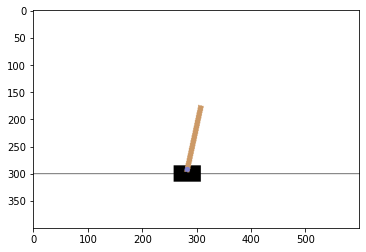

21 True


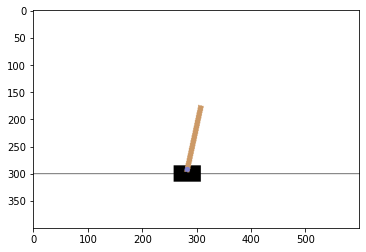

In [150]:
num_actions = 0
while True:
  action = model.action(state)
  next_state, reward, done, _ = env.step(action)
  plt.imshow(env.render('rgb_array'))
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
  num_actions+=1
  print (num_actions, done)
  if done:
    break

In [58]:
N = 1000 # Replay Buffer Capacity
M = 200  # Number of Episodes
T = 200  # Number of frames
LR = 0.001 # Learning Rate

# Initialize replay memory D to capacity N
replay_buffer = ReplayBuffer(N)
# Initialize action-value function Q with random weights
model = testDQN(env.observation_space.shape[0], env.action_space.n)

# for episode = 1, M do
for episode in range(M):
  # Initialize sequence s1 = {x} and preprocessed sequenced
  env.reset()
  episode_reward = 0
  # for t = 1, T do
    for t in range(T):
      # With probability e select a random action a otherwise select a = max(Q)
      action = model.act(state, epsilon)
      # Execute action in emulator and observe reward and image
      next_state, reward, done, _ = env.step (action)
      # Store transition in D 
      replay_buffer.push(state, action, reward, next_state, done)
      # Set S(t+1) = st, at, x(t+1) and preprocess 
      state = next_state
      episode_reward += reward
      # Sample Random minibatch of transitions from D
      if len(replay_buffer) > minibatchSize:
      if done:
          break;


SyntaxError: ignored

### Hyperparameters

#### Grid Search, Random Search, Bayesian Optimization, Hyperband
#### [Parameter Prioritization](https://www.wandb.com/articles/running-hyperparameter-sweeps-to-pick-the-best-model-using-w-b)

### learning rate, loss function, layer_size
### weight initialization, model depth, layer params, weight of regularization
### optimizer choice, optimize params, batch size, nonlinearity



Observation space: 4
Action space: Discrete(2)


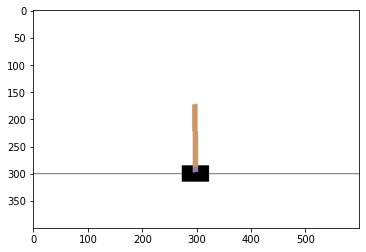

In [60]:
obs0 = env.reset()
plt.imshow(env.render('rgb_array'))
print("Observation space:", env.observation_space.shape[0])
print("Action space:", env.action_space)

In [67]:
next_state, reward, done, _ = env.step(1)
print (next_state)
print (reward)
print (done)

[-0.03664301  0.18741413 -0.04669343 -0.28398814]
1.0
False


In [0]:
num_epochs = ""
batch_size = ""
num_layers = ""
num_nodes  = ""

In [0]:
next_state, reward, done, _ = env.reset()

In [66]:
print (next_state)
print (reward)

-0.03647598403282501
-0.008351262898676562
